# Chapter 10

In [3]:
!pip install torchinfo && touch /root/.ipython/profile_default/startup/00-first.py && echo "import torchinfo" >> /root/.ipython/profile_default/startup/00-first.py

In [4]:
!pip install torchvision && touch /root/.ipython/profile_default/startup/00-first.py && echo "import torchvision" >> /root/.ipython/profile_default/startup/00-first.py

In [54]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)

import torch
from torch import nn
from torch.optim import (RMSprop, Adam)
from torch.utils.data import TensorDataset

from torchmetrics import (MeanAbsoluteError,R2Score)
from torchinfo import summary
from torchvision.io import read_image

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from lightning_lite.utilities.seed import seed_everything

seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)

from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)
from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)
import torch.optim as optim
import statsmodels.api as sm
from glob import glob
import json


Global seed set to 0


## Exercise 6

In [ ]:
def R(beta):
  return np.sin(beta)+beta/10

### (a)

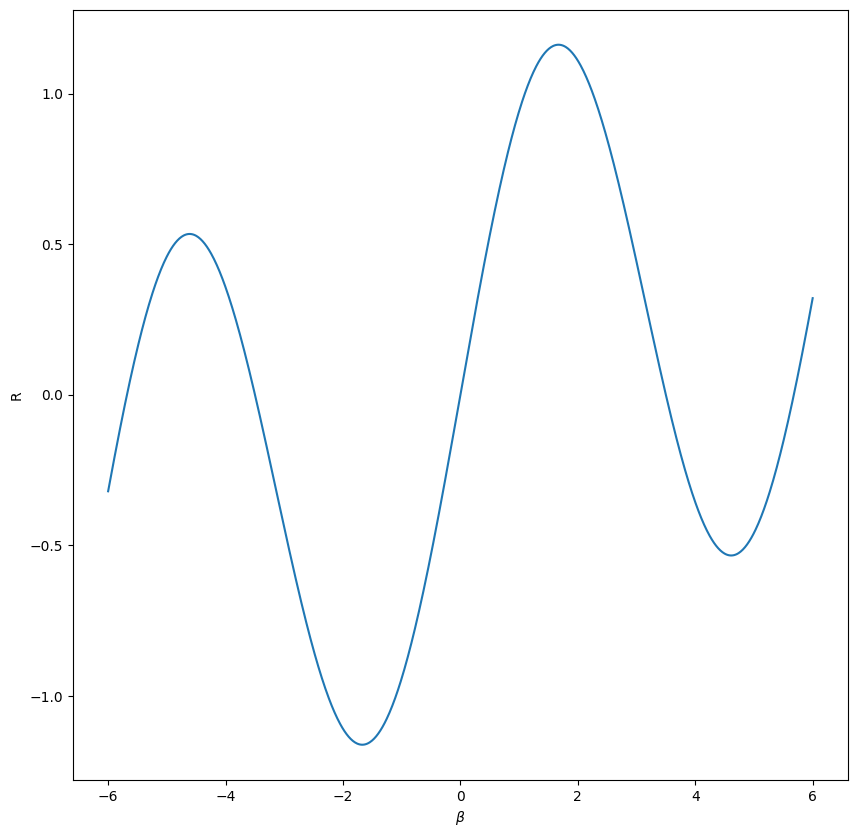

In [ ]:
fig,ax=subplots(figsize=(10,10))
beta=np.linspace(-6, 6, 1000)
y=R(beta)
ax.plot(beta,y)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel('R');

### (b)

Derivative of the function $R(\beta)$ is $R^{'}(\beta)=cos(\beta)+1/10$

### (c)

In [ ]:
def deR(beta):
  return np.cos(beta)+1/10

In [ ]:
#Let's define the function gradient_descent which returns a tuple containing both the extermal point and the point at which it occurs
def gradient_descent(init_point,objective=R, derivative=deR, n_iter=30, step_size=0.1):
  betas, scores = [], []
  for i in range(n_iter):
    gradient = derivative(init_point)
    init_point = init_point - step_size * gradient
    solution_eval = objective(init_point)
    betas.append(init_point)
    scores.append(solution_eval)
  return [betas, scores]

In [ ]:
solutions, scores = gradient_descent(init_point=2.3,n_iter=50)

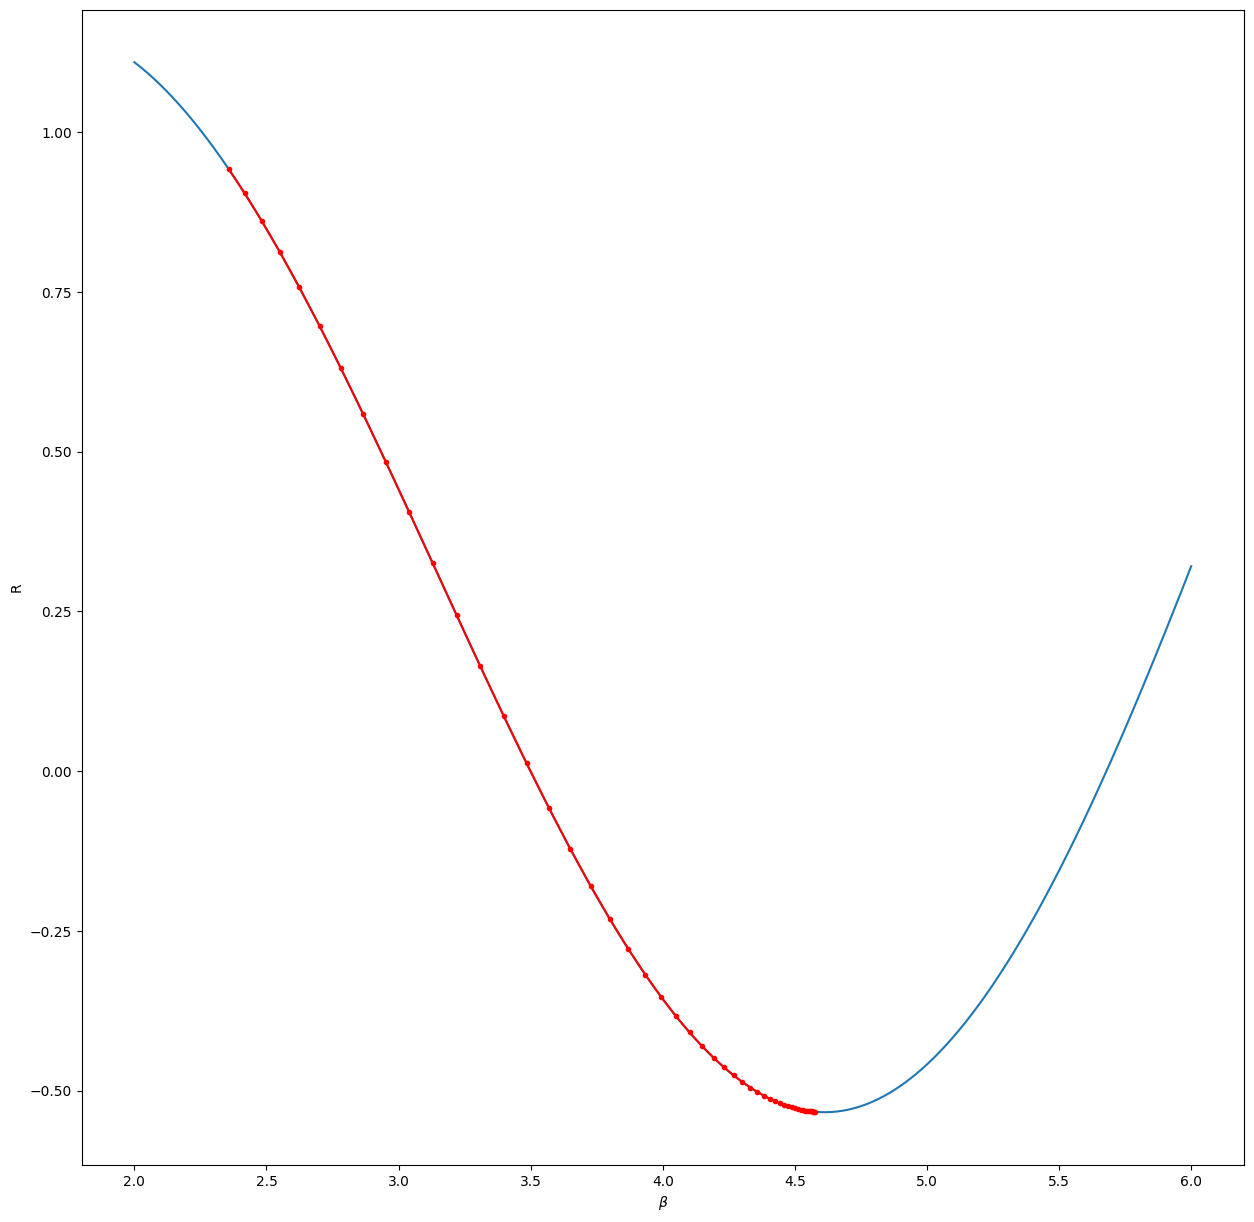

In [ ]:
fig,ax=subplots(figsize=(15,15))
beta=np.linspace(2, 6, 1000)
y=R(beta)
ax.plot(beta,y)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel('R')
ax.plot(solutions,scores,'.-', color='red');

### (d)

In [ ]:
solutions, scores = gradient_descent(init_point=1.4,n_iter=70)

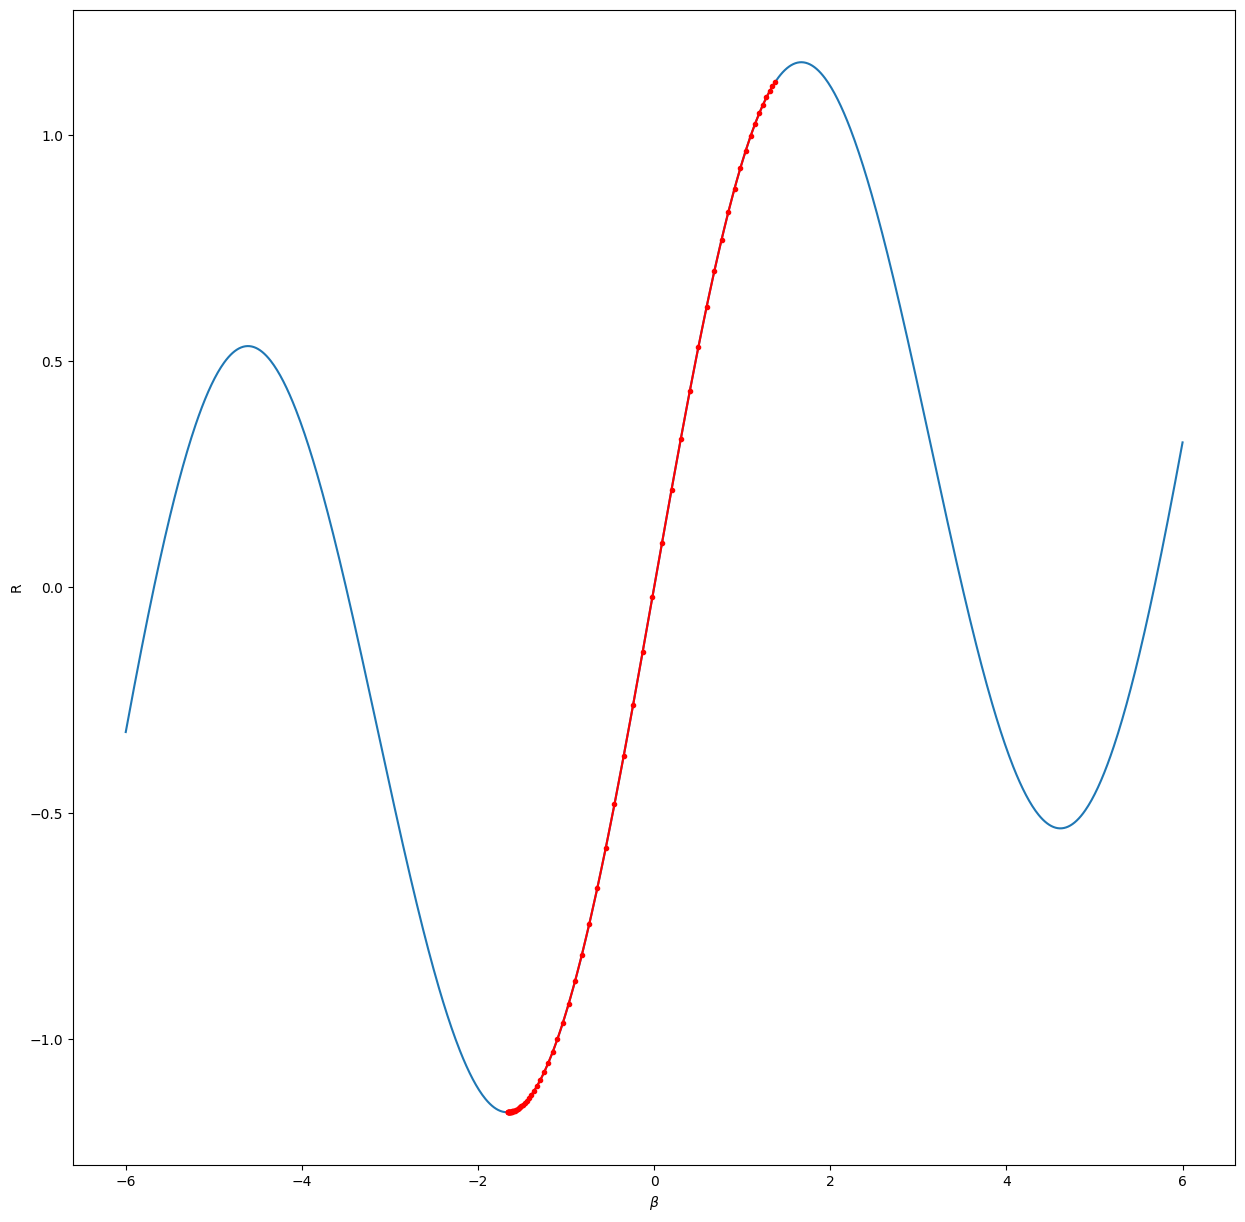

In [ ]:
fig,ax=subplots(figsize=(15,15))
beta=np.linspace(-6, 6, 1000)
y=R(beta)
ax.plot(beta,y)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel('R')
ax.plot(solutions,scores,'.-', color='red');

## Exercise 7

In [ ]:
Default=load_data("Default")

In [ ]:
Default.head()

default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879

In [ ]:
Default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [ ]:
Default['default']=np.where(Default['default']=='Yes',int(1),int(0))
Default['student']=np.where(Default['student']=='Yes',int(1),int(0))

In [ ]:
model=MS(Default.columns.drop('default'),intercept=False)
X=model.fit_transform(Default).to_numpy()
Y=Default['default'].to_numpy()

In [ ]:
(X_train,X_test,Y_train,Y_test)=train_test_split(X,Y,test_size=1/3,random_state=10)

In [ ]:
class DefaultModel(nn.Module):
  def __init__(self,input_size):
    super(DefaultModel,self).__init__()
    self.flatten=nn.Flatten()
    self.sequential=nn.Sequential(
        nn.Linear(input_size,10),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(10,1),
        nn.Sigmoid())#use Sigmoid function because the response is qualitative with only classes
  def forward(self,x):
    x=self.flatten(x)
    return torch.flatten(self.sequential(x))

In [ ]:
Default_Model=DefaultModel(X.shape[1])

In [ ]:
#Form the tensor dataset for the training set
X_train_t=torch.tensor(X_train.astype(np.float32))
Y_train_t=torch.tensor(Y_train.astype(np.float32))
Default_train=TensorDataset(X_train_t,Y_train_t)

In [ ]:
Default_Model(X_train_t)

tensor([0.5313, 0.0000, 1.0000,  ..., 1.0000, 0.0000, 0.5313],
       grad_fn=<ReshapeAliasBackward0>)

In [ ]:
#Form the tensor dataset for the test set
X_test_t=torch.tensor(X_test.astype(np.float32))
Y_test_t=torch.tensor(Y_test.astype(np.float32))
Default_test=TensorDataset(X_test_t,Y_test_t)

In [ ]:
#Define the number of processes to use when loading the data in the network
max_num_workers=rec_num_workers()

In [ ]:
Default_dm=SimpleDataModule(Default_train,Default_test,batch_size=32,num_workers=min(4,max_num_workers),validation=Default_test)

In [ ]:
# We use the cross-entropy as a performance metric of the model
Default_module=SimpleModule.classification(Default_Model,num_classes=2)

In [ ]:
#Form a results ledger
Default_logger=CSVLogger('logs',name='default')

In [ ]:
Default_trainer=Trainer(deterministic=True,
                        max_epochs=50,
                        log_every_n_steps=208,
                        logger=Default_logger,
                        callbacks=[ErrorTracker()])
Default_trainer.fit(Default_module,datamodule=Default_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | DefaultModel     | 51    
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
51        Trainable params
0         Non-trainable params
51        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
Default_trainer.test(Default_module , datamodule=Default_dm)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9628074169158936     │
│         test_loss         │    1005.8790283203125     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1005.8790283203125, 'test_accuracy': 0.9628074169158936}]

In [ ]:
# Fit logistic regression
glm = sm.GLM(Y_train,X_train,family=sm.families.Binomial())
results = glm.fit()
summarize(results)

coef   std err       z  P>|z|
x1 -3.6731  0.187000 -19.600    0.0
x2  0.0027  0.000000  17.481    0.0
x3 -0.0002  0.000006 -27.305    0.0

In [ ]:
probs = results.predict(X_test)

In [ ]:
labels=np.array([0]*X_test.shape[0])
labels[probs>0.5]=1#Remember 1 means that default has occured

In [ ]:
C=ISLP.confusion_table(labels,Y_test)

In [ ]:
C

Truth         0    1
Predicted           
0          3195  118
1            15    6

In [ ]:
(3195+6)/Y_test.shape[0]

0.9601079784043192

The sequential neural network and logistic regression models have approximately the same test performance.

## Exercise 8

I curiously had never images of animals in my personal collection, so I tried to gather 10 license free images from https://www.pexels.com/.<br>
The names of the images were maintained for the ease of finding them in the mentionned url.<br>
Big thanks to the photographers!


In [ ]:
#The following lines are added to use glob function, since I used here Google colab
#Input images in jpg format were registered in the Colab Notebooks file located in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
resize=Resize((232,232))
crop=CenterCrop(224)
normalize=Normalize([0.485 ,0.456 ,0.406] ,[0.229 ,0.224 ,0.225])
imgfiles = sorted([f for f in glob('/content/drive/My Drive/Colab Notebooks/*.jpg')])
imgs=torch.stack([torch.div(crop(resize(read_image(f))), 255) for f in imgfiles])
imgs=normalize(imgs)
imgs.size()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([10, 3, 224, 224])

In [ ]:
#Set up the resnet50 model
resnet_model=resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 112MB/s]


In [ ]:
#Ensure the model is ready to work
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#Feed the images through the resnet50 model
img_preds=resnet_model(imgs)

In [ ]:
#Compute the probabilities of classification
img_probs=np.exp(np.asarray(img_preds.detach()))
img_probs/=img_probs.sum(1)[:,None]

In [ ]:
#Download image labels
labs=json.load(open('/content/drive/My Drive/Colab Notebooks/imagenet_class_index.json'))#File imagenet_class_index was downloaded as indicated
# in page 453 of the book
class_labels=pd.DataFrame([(int(i),k[1]) for i,k in labs.items()],columns=['index','label'])
class_labels=class_labels.set_index('index')
class_labels=class_labels.sort_index()

In [ ]:
for i, imgfile in enumerate(imgfiles):
  img_df = class_labels.copy()
  img_df['prob'] = img_probs[i]
  img_df = img_df.sort_values(by='prob', ascending=False )[:5]
  print(f'Image: {imgfile}')
  print(img_df.reset_index ().drop(columns=['index']))

Image: /content/drive/My Drive/Colab Notebooks/pexels-alex-andrews-2295744.jpg
      label      prob
0   kit_fox  0.259589
1   red_fox  0.158943
2  grey_fox  0.015072
3    coyote  0.003609
4  fountain  0.003354
Image: /content/drive/My Drive/Colab Notebooks/pexels-carlos-spitzer-17811.jpg
          label      prob
0        toucan  0.470154
1       jacamar  0.001613
2     parachute  0.001561
3  anemone_fish  0.001100
4     bee_eater  0.001063
Image: /content/drive/My Drive/Colab Notebooks/pexels-charles-1851164.jpg
                       label      prob
0                        pug  0.332863
1          Brabancon_griffon  0.138937
2                      boxer  0.014477
3                tennis_ball  0.011284
4  Staffordshire_bullterrier  0.007482
Image: /content/drive/My Drive/Colab Notebooks/pexels-elianne-dipp-4666751.jpg
               label      prob
0  great_white_shark  0.171255
1         grey_whale  0.093352
2              wreck  0.046258
3         breakwater  0.045020
4           

Out of the 10 input images, 2 were misclassified. The model deemed a whale as a shark and a horse as a bighorn.

## Exercise 9

In [ ]:
NYSE=load_data('NYSE')
cols=['DJ_return','log_volume','log_volatility']
X=pd.DataFrame(StandardScaler(with_mean=True,with_std=True).fit_transform(NYSE[cols]),columns=NYSE[cols].columns,index=NYSE.index)

In [ ]:
NYSE

day_of_week  DJ_return  log_volume  log_volatility  train
date                                                                
1962-12-03         mon  -0.004461    0.032573      -13.127403   True
1962-12-04        tues   0.007813    0.346202      -11.749305   True
1962-12-05         wed   0.003845    0.525306      -11.665609   True
1962-12-06        thur  -0.003462    0.210182      -11.626772   True
1962-12-07         fri   0.000568    0.044187      -11.728130   True
...                ...        ...         ...             ...    ...
1986-12-24         wed   0.006514   -0.236104       -9.807366  False
1986-12-26         fri   0.001825   -1.322425       -9.906025  False
1986-12-29         mon  -0.009515   -0.371237       -9.827660  False
1986-12-30        tues  -0.001837   -0.385638       -9.926091  False
1986-12-31         wed  -0.006655   -0.264986       -9.935527  False

[6051 rows x 5 columns]

In [ ]:
#Set up the number of lags
L=5
for lag in range(1,L+1):
  for col in cols:
    newcol=np.zeros(X.shape[0])*np.nan
    newcol[lag:]=X[col].values[:-lag]
    X.insert(len(X.columns),'{0}_{1}'.format(col,lag),newcol)
X.insert(len(X.columns),'train',NYSE['train'])
X=X.dropna()

In [ ]:
Y,train=X['log_volume'],X['train']
X=X.drop(columns=['train']+cols)

In [ ]:
M=LinearRegression()
M.fit(X[train],Y[train])
M.score(X[~train],Y[~train])

0.4128912938562521

In [ ]:
#Refit the model with a 12-level factor representing the month
month=[]
for i in range(len(NYSE.index)):
  month.append(NYSE.index[i][5:7])
Month=pd.DataFrame(month,index=NYSE.index)

In [ ]:
X_month=pd.merge(X,pd.get_dummies(Month),on='date')
M.fit(X_month[train], Y[train])
M.score(X_month[~train], Y[~train])

0.4167123048568927

The integration of the month only improves the $R^2$ with $0.4$%.

## Exercise 10

In [ ]:
#Flatten the RNN without the feature set X_day and exclude hidden layers to reconstruct AR with lag=5
NYSE=load_data('NYSE')
cols=['DJ_return','log_volume','log_volatility']
X=pd.DataFrame(StandardScaler(with_mean=True,with_std=True).fit_transform(NYSE[cols]),columns=NYSE[cols].columns,index=NYSE.index)

In [ ]:
#Set up the number of lags
L=5
for lag in range(1,L+1):
  for col in cols:
    newcol=np.zeros(X.shape[0])*np.nan
    newcol[lag:]=X[col].values[:-lag]
    X.insert(len(X.columns),'{0}_{1}'.format(col,lag),newcol)
X.insert(len(X.columns),'train',NYSE['train'])
X=X.dropna()

In [ ]:
Y,train=X['log_volume'],X['train']
X=X.drop(columns=['train']+cols)

In [ ]:
#Reorder columns and reshape data
ordered_cols = []
for lag in range(5,0,-1):
  for col in cols:
    ordered_cols.append('{0}_{1}'.format(col , lag))
X = X.reindex(columns=ordered_cols)
X_rnn = X.to_numpy().reshape((-1,5,3))
X_rnn.shape

(6046, 5, 3)

In [ ]:
#Form the training and test data set
datasets = []
for mask in [train , ~train]:
  X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
  Y_t = torch.tensor(Y[mask].astype(np.float32))
  datasets.append(TensorDataset(X_rnn_t , Y_t))
nyse_train , nyse_test = datasets

In [ ]:
#Create data module
max_num_workers=rec_num_workers()
nyse_dm = SimpleDataModule(nyse_train,nyse_test,num_workers=min(4, max_num_workers),validation=nyse_test,batch_size =64)

In [ ]:
class LinearARModel(nn.Module):
  def __init__(self):
    super(LinearARModel , self).__init__()
    self._forward = nn.Sequential(nn.Flatten(),
    nn.Linear(15,20),
    nn.Dropout (0.5),
    nn.Linear(20, 1))
  def forward(self , x):
    return torch.flatten(self._forward(x))

In [ ]:
l_model=LinearARModel()
l_optimizer = RMSprop(l_model.parameters(),lr=0.001)
l_module = SimpleModule.regression(l_model ,optimizer=l_optimizer ,metrics={'r2':R2Score ()})

In [ ]:
l_trainer = Trainer(deterministic=True ,max_epochs=20,callbacks=[ErrorTracker()])
l_trainer.fit(l_module , datamodule=nyse_dm)
l_trainer.test(l_module , datamodule=nyse_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params
----------------------------------------
0 | model | LinearARModel | 341   
1 | loss  | MSELoss       | 0     
----------------------------------------
341       Trainable params
0         Non-trainable params
341       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6268699765205383     │
│          test_r2          │    0.40506982803344727    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6268699765205383, 'test_r2': 0.40506982803344727}]

$R^2=0.4051$ which is approximately the same value obtained for the same problem using AR(5) (see page 461 where $R^2=0.4129$)

## Exercise 11

In [ ]:
NYSE=load_data('NYSE')
cols=['DJ_return','log_volume','log_volatility']
X=pd.DataFrame(StandardScaler(with_mean=True,with_std=True).fit_transform(NYSE[cols]),columns=NYSE[cols].columns,index=NYSE.index)

In [ ]:
L=5
for lag in range(1,L+1):
  for col in cols:
    newcol=np.zeros(X.shape[0])*np.nan
    newcol[lag:]=X[col].values[:-lag]
    X.insert(len(X.columns),'{0}_{1}'.format(col,lag),newcol)
X.insert(len(X.columns),'train',NYSE['train'])
X=X.dropna()

In [ ]:
Y,train=X['log_volume'],X['train']
X=X.drop(columns=['train']+cols)

In [ ]:
ordered_cols = []
for lag in range(5,0,-1):
  for col in cols:
    ordered_cols.append('{0}_{1}'.format(col , lag))
X = X.reindex(columns=ordered_cols)
X_rnn = X.to_numpy().reshape((-1,5,3))
X_rnn.shape

(6046, 5, 3)

In [ ]:
datasets = []
for mask in [train , ~train]:
  X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
  Y_t = torch.tensor(Y[mask].astype(np.float32))
  datasets.append(TensorDataset(X_rnn_t , Y_t))
nyse_train , nyse_test = datasets

In [ ]:
max_num_workers=rec_num_workers()
nyse_dm = SimpleDataModule(nyse_train,nyse_test,num_workers=min(4, max_num_workers),validation=nyse_test,batch_size =64)

In [ ]:
class NonLinearARModel(nn.Module):
  def __init__(self):
    super(NonLinearARModel , self).__init__()
    self._forward = nn.Sequential(nn.Flatten(),
    nn.Linear(15,32),
    nn.ReLU(),
    nn.Dropout (0.5),
    nn.Linear(32, 1))
  def forward(self , x):
    return torch.flatten(self._forward(x))

In [ ]:
nl_model=NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(),lr=0.001)
nl_module = SimpleModule.regression(nl_model ,optimizer=nl_optimizer ,metrics={'r2':R2Score ()})

In [ ]:
nl_trainer = Trainer(deterministic=True ,max_epochs=20,callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module , datamodule=nyse_dm)
nl_trainer.test(nl_module , datamodule=nyse_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | NonLinearARModel | 545   
1 | loss  | MSELoss          | 0     
-------------------------------------------
545       Trainable params
0         Non-trainable params
545       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6089999675750732     │
│          test_r2          │    0.4220293164253235     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6089999675750732, 'test_r2': 0.4220293164253235}]

The $R^2$ metric is 0.422.

## Exercise 12

In [102]:
NYSE=load_data('NYSE')
cols=['DJ_return','log_volume','log_volatility']
X=pd.DataFrame(StandardScaler(with_mean=True,with_std=True).fit_transform(NYSE[cols]),columns=NYSE[cols].columns,index=NYSE.index)

In [103]:
L=5
for lag in range(1,L+1):
  for col in cols:
    newcol=np.zeros(X.shape[0])*np.nan
    newcol[lag:]=X[col].values[:-lag]
    X.insert(len(X.columns),'{0}_{1}'.format(col,lag),newcol)
X.insert(len(X.columns),'train',NYSE['train'])
X=X.dropna()

In [105]:
Y,train=X['log_volume'],X['train']
X=X.drop(columns=['train']+cols)
X_day = pd.merge(X,pd.get_dummies(NYSE['day_of_week']),on='date')

In [107]:
ordered_cols = []
for lag in range(5,0,-1):
  for col in cols:
    ordered_cols.append('{0}_{1}'.format(col , lag))
X_day = X_day.reindex(columns=ordered_cols)


In [111]:
X_day= pd.merge(X_day,pd.get_dummies(NYSE['day_of_week']),on='date')

In [114]:
X_rnn = X_day.to_numpy().reshape((-1,5,4))

In [116]:
class NYSEModel(nn.Module):
  def __init__(self):
    super(NYSEModel , self).__init__()
    self.rnn = nn.RNN(4,12,batch_first=True)
    self.dense = nn.Linear(12, 1)
    self.dropout = nn.Dropout (0.1)
  def forward(self , x):
    val , h_n = self.rnn(x)
    val = self.dense(self.dropout(val[:,-1]))
    return torch.flatten(val)
nyse_model = NYSEModel()

In [118]:
datasets = []
for mask in [train , ~train]:
  X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
  Y_t = torch.tensor(Y[mask].astype(np.float32))
  datasets.append(TensorDataset(X_rnn_t , Y_t))
nyse_train , nyse_test = datasets

In [119]:
max_num_workers=rec_num_workers()
nyse_dm = SimpleDataModule(nyse_train ,nyse_test,num_workers=min(4, max_num_workers),validation=nyse_test,batch_size =128)

In [120]:
nyse_optimizer = Adam(nyse_model.parameters(),lr=0.0001)
nyse_module = SimpleModule.regression(nyse_model,optimizer=nyse_optimizer ,metrics={'r2':R2Score()})

In [121]:
nyse_trainer = Trainer(deterministic=True ,max_epochs =200,callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module ,datamodule=nyse_dm)
nyse_trainer.test(nyse_module,datamodule=nyse_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | model | NYSEModel | 229   
1 | loss  | MSELoss   | 0     
------------------------------------
229       Trainable params
0         Non-trainable params
229       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5852503776550293     │
│          test_r2          │    0.44456881284713745    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5852503776550293, 'test_r2': 0.44456881284713745}]

The test $R^2$ is 0.4447, which is better than the value obtained with incorporating the 'day_of_week' feature (see page 464 of the book where $R^2=0.4172$).

## Exercise 13

In [122]:
(imdb_seq_train ,
imdb_seq_test) = load_sequential(root='data/IMDB')
padded_sample = np.asarray(imdb_seq_train.tensors [0][0])

Retrieving "IMDB_S_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_S_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_Y_test.npy" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_Y_train.npy" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


In [123]:
max_num_workers =10
(imdb_train ,imdb_test) = load_tensor(root='data/IMDB')
imdb_dm = SimpleDataModule(imdb_train,imdb_test,validation =2000,num_workers=min(6, max_num_workers),batch_size =512)

Retrieving "IMDB_X_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


In [125]:
#two layer model with 32 units per layer and with dropout regularization
class IMDBModel32D(nn.Module):
  def __init__(self , input_size):
    super(IMDBModel32D , self).__init__()
    self.dense1 = nn.Linear(input_size , 32)
    self.activation = nn.ReLU()
    self.dropout=nn.Dropout(0.3)
    self.dense2 = nn.Linear(32, 32)
    self.output = nn.Linear(32, 1)
  def forward(self , x):
    val = x
    for _map in [self.dense1,self.activation, self.dropout,self.dense2,self.activation, self.dropout,self.output]:
      val = _map(val)
    return torch.flatten(val)

In [126]:
imdb_model32d = IMDBModel32D(imdb_test.tensors [0].size()[1])

In [127]:
imdb_optimizer32d = RMSprop(imdb_model32d.parameters(), lr=0.001)
imdb_module32d = SimpleModule.binary_classification(imdb_model32d,optimizer=imdb_optimizer32d)

In [128]:
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True ,max_epochs=30,logger=imdb_logger ,callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module32d ,datamodule=imdb_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params
--------------------------------------------
0 | model | IMDBModel32D      | 321 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
321 K     Trainable params
0         Non-trainable params
321 K     Total params
1.285     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [129]:
test_results32d = imdb_trainer.test(imdb_module32d , datamodule=imdb_dm)
test_results32d

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8664799928665161     │
│         test_loss         │    1.1246744394302368     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.1246744394302368, 'test_accuracy': 0.8664799928665161}]

The case where there are 32 units per layer with drop regularization yields a test accuracy of 0.87.

In [132]:
#two layer model with 32 units per layer and without dropout regularization
class IMDBModel32WO(nn.Module):
  def __init__(self , input_size):
    super(IMDBModel32WO , self).__init__()
    self.dense1 = nn.Linear(input_size , 32)
    self.activation = nn.ReLU()
    self.dense2 = nn.Linear(32, 32)
    self.output = nn.Linear(32, 1)
  def forward(self , x):
    val = x
    for _map in [self.dense1,self.activation, self.dense2,self.activation, self.output]:
      val = _map(val)
    return torch.flatten(val)

In [133]:
imdb_model32wo = IMDBModel32WO(imdb_test.tensors [0].size()[1])

In [134]:
imdb_optimizer32wo = RMSprop(imdb_model32wo.parameters(), lr=0.001)
imdb_module32wo = SimpleModule.binary_classification(imdb_model32wo,optimizer=imdb_optimizer32wo)

In [135]:
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True ,max_epochs=30,logger=imdb_logger ,callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module32wo ,datamodule=imdb_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params
--------------------------------------------
0 | model | IMDBModel32WO     | 321 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
321 K     Trainable params
0         Non-trainable params
321 K     Total params
1.285     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [136]:
test_results32wo = imdb_trainer.test(imdb_module32wo , datamodule=imdb_dm)
test_results32wo

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.85316002368927      │
│         test_loss         │    1.2466514110565186     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.2466514110565186, 'test_accuracy': 0.85316002368927}]

The case where there are 32 units per layer without drop regularization yields a test accuracy of 0.85. (As expected, regularization must improve the accuracy)

In [137]:
#two layer model with 64 units per layer and with dropout regularization
class IMDBModel64D(nn.Module):
  def __init__(self , input_size):
    super(IMDBModel64D , self).__init__()
    self.dense1 = nn.Linear(input_size , 64)
    self.activation = nn.ReLU()
    self.dropout=nn.Dropout(0.3)
    self.dense2 = nn.Linear(64, 64)
    self.output = nn.Linear(64, 1)
  def forward(self , x):
    val = x
    for _map in [self.dense1,self.activation, self.dense2,self.activation, self.output]:
      val = _map(val)
    return torch.flatten(val)

In [138]:
imdb_model64d = IMDBModel64D(imdb_test.tensors [0].size()[1])

In [139]:
imdb_optimizer64d = RMSprop(imdb_model64d.parameters(), lr=0.001)
imdb_module64d = SimpleModule.binary_classification(imdb_model64d,optimizer=imdb_optimizer64d)

In [140]:
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True ,max_epochs=30,logger=imdb_logger ,callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module64d ,datamodule=imdb_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params
--------------------------------------------
0 | model | IMDBModel64D      | 644 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
644 K     Trainable params
0         Non-trainable params
644 K     Total params
2.578     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [141]:
test_results64d = imdb_trainer.test(imdb_module64d , datamodule=imdb_dm)
test_results64d

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.85944002866745      │
│         test_loss         │    1.4745968580245972     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.4745968580245972, 'test_accuracy': 0.85944002866745}]

The case where there are 64 units per layer with drop regularization yields a test accuracy of 0.86.

---



In [142]:
#two layer model with 64 units per layer and without dropout regularization
class IMDBModel64WO(nn.Module):
  def __init__(self , input_size):
    super(IMDBModel64WO , self).__init__()
    self.dense1 = nn.Linear(input_size , 64)
    self.activation = nn.ReLU()
    self.dense2 = nn.Linear(64, 64)
    self.output = nn.Linear(64, 1)
  def forward(self , x):
    val = x
    for _map in [self.dense1,self.activation, self.dense2,self.activation, self.output]:
      val = _map(val)
    return torch.flatten(val)

In [143]:
imdb_model64wo = IMDBModel64WO(imdb_test.tensors [0].size()[1])

In [144]:
imdb_optimizer64wo = RMSprop(imdb_model64wo.parameters(), lr=0.001)
imdb_module64wo = SimpleModule.binary_classification(imdb_model64wo,optimizer=imdb_optimizer64wo)

In [145]:
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True ,max_epochs=30,logger=imdb_logger ,callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module64wo ,datamodule=imdb_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params
--------------------------------------------
0 | model | IMDBModel64WO     | 644 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
644 K     Trainable params
0         Non-trainable params
644 K     Total params
2.578     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [146]:
test_results64wo = imdb_trainer.test(imdb_module64wo , datamodule=imdb_dm)
test_results64wo

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.858240008354187     │
│         test_loss         │    1.4918928146362305     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.4918928146362305, 'test_accuracy': 0.858240008354187}]

The case where there are 64 units per layer without drop regularization yields a test accuracy of 0.86.

---

